In [1]:
from dolfin import *
import numpy as np
import scipy.io

Consider the following stream function
$$
\psi(r,\theta,z) = \frac{1}{2}r^2\left(1-{r^2}-4{z^2}\right).
$$
This function generates eliptical vortex. The induced velocity in cylindrical coordinates is given below
$$
\frac{dr}{dt}=-\frac{1}{r}\frac{\partial\psi}{\partial z}=4rz\\
\frac{dz}{dt}=\frac{1}{r}\frac{\partial\psi}{\partial r}=1-2r^2-4z^2\\
\frac{d\theta}{dt}=0
$$
To obtain well-defined stream surfaces, we add rigid body notation as below
$$
\frac{d\theta}{dt}=\Omega
$$

The velocity components in Cartesian coordiantes are given as below
$$
u_x = \dot{r}\cos\theta-r\sin\theta\dot{\theta} = 4xz-y\Omega,\\
u_y = \dot{r}\sin\theta+r\cos\theta\dot{\theta} = 4yz+x\Omega,\\
u_z = 1-2(x^2+y^2)-4z^2.
$$

Again, the constructed stream function is a solution to first integral.

In [2]:
def preprocessingData():
    # load velocity data
    data = scipy.io.loadmat('taylorvortex_rphiz_grid.mat') # 
    rr = data['rgrid']
    th = data['phigrid']
    zz = data['zgrid']
    rr = rr.flatten()
    th = th.flatten()
    zz = zz.flatten()
    nr  = rr.shape[0]
    nth = th.shape[0]
    nz  = zz.shape[0]
    vxgrid = data['vx']
    vygrid = data['vy']
    vzgrid = data['vz']

    # check periodic conditions of the augmented data
    df = vxgrid[:,:,nz-1] - vxgrid[:,:,0]
    print('pc vx in z:',max(df.flatten()))
    df = vygrid[:,:,nz-1] - vygrid[:,:,0]
    print('pc vy in z:',max(df.flatten()))
    df = vzgrid[:,:,nz-1] - vzgrid[:,:,0]
    print('pc vz in z:',max(df.flatten()))
        
    return rr,th,zz,vxgrid,vygrid,vzgrid

In [3]:
# Sub domain for Dirichlet boundary condition
class DirichletBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return ((near(sqrt(x[0]*x[0]+x[1]*x[1]), 1, 0.02) or near(sqrt(x[0]*x[0]+x[1]*x[1]), 2, 0.02)) and
                (not (near(x[2],0) or near(x[2],pi))) and on_boundary)

    
class PeriodicBoundary(SubDomain):

    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        return bool ((near(x[2], 0) or near(x[2], pi)) and on_boundary)

    # Map right boundary (H) to left boundary (G)
    def map(self, x, y):
    	#### define mapping for a edges in the box, such that mapping in 2 Cartesian coordinates are required
        if near(x[2], pi):
            y[0] = x[0] 
            y[1] = x[1]
            y[2] = x[2] - pi
        else:
            y[0] = -10000
            y[1] = -10000
            y[2] = -10000
            

In [4]:
def cart2pol(coor):
    x,y = coor[:,0],coor[:,1]
    r = np.sqrt(x**2+y**2)
    t = np.arctan2(y,x) 
    negidx = t<0
    t[negidx] = t[negidx]+2*np.pi    
    cart_coor = np.array([r,t,coor[:,2]])
    
    return cart_coor.T

In [5]:
def eigenvalues(X, V):
#
    # Define the bilinear forms on the right- and left-hand sides
    H = TrialFunction(V)
    h = TestFunction(V)
    a = (inner(X,grad(H))*inner(X, grad(h)))*dx 
    b = inner(H,h)*dx
#
    # Assemble into PETSc matrices
    A = PETScMatrix()
    assemble(a, tensor=A)
    B = PETScMatrix()
    assemble(b, tensor=B)
#
    solver = SLEPcEigenSolver(A, B)
    solver.parameters["solver"] = "krylov-schur" # "lapack" # "lanczos" # "krylov-schur" - not good for high-fidelty discretization
    solver.parameters["problem_type"] = "gen_hermitian"
    #solver.parameters["maximum_iterations"] = 10000
    #solver.parameters['tolerance'] = 1.e-14
    solver.parameters["spectrum"] = "target magnitude"
    solver.parameters["spectral_transform"] = "shift-and-invert"
    solver.parameters["spectral_shift"] = -0.1 # 0 is not working, 1e-14 or negative number (-0.1) works fine
    
    neigs = 4
    solver.solve(neigs)
    # print("number of iterations is ",solver.get_iteration_number())
    print("number of converged eigenvalues: ",solver.get_number_converged())
#
    # Return the computed eigenvalues in a sorted array
    computed_eigenvalues = []
    for i in range(min(neigs, solver.get_number_converged())):
        r, _ = solver.get_eigenvalue(i) # ignore the imaginary part
        computed_eigenvalues.append(r)
        print("eigenvalue: ", r)
    # Return the H corresponding to the first and second eigenvalue
    print("return the first eienvector")
    r, c, rx, cx = solver.get_eigenpair(0)
    # Turn the eigenvector into a Function:
    rx_func0 = Function(V)
    rx_func0.vector()[:] = rx
    print("return the second eienvector")
    r, c, rx, cx = solver.get_eigenpair(1)
    # Turn the eigenvector into a Function:
    rx_func1 = Function(V)
    rx_func1.vector()[:] = rx
    print("return the third eienvector")
    r, c, rx, cx = solver.get_eigenpair(1)
    # Turn the eigenvector into a Function:
    rx_func2 = Function(V)
    rx_func2.vector()[:] = rx
    
    return np.array(computed_eigenvalues), rx_func0, rx_func1, rx_func2


In [6]:
def plot_results(rhosamp,thetasamp,zsamp,dirname,H1,Href,mode):
    from matplotlib import pyplot as plt
    nrho = np.size(rhosamp)
    nth  = np.size(thetasamp)
    nz   = np.size(zsamp)
    Rhosamp = np.concatenate((-np.flipud(rhosamp),rhosamp))
    RHO1,Z1   = np.meshgrid(rhosamp,zsamp)
    RHO2,Z2   = np.meshgrid(-np.flipud(rhosamp),zsamp)
    hx1 = H1[:,np.argmin(abs(thetasamp-0.5*pi)),:]
    hx1 = np.reshape(hx1,[nrho,nz])
    hx2 = H1[:,np.argmin(abs(thetasamp-1.5*pi)),:]
    hx2 = np.reshape(hx2,[nrho,nz])
    hx2 = np.flipud(hx2)
    plt.figure()
    plt.subplot(1,2,1)
    cs = plt.contour(RHO1,Z1,hx1.T,100)
    plt.subplot(1,2,2)
    cs = plt.contour(RHO2,Z2,hx2.T,cs.levels)
    plt.colorbar()   
    plt.title('x=0 '+'mode'+str(mode))
    plt.savefig(dirname+'/x'+'mode'+str(mode)+'.png')  
    
    hy1 = H1[:,np.argmin(abs(thetasamp-0)),:]
    hy1 = np.reshape(hy1,[nrho,nz])
    hy2 = H1[:,np.argmin(abs(thetasamp-pi)),:]
    hy2 = np.reshape(hy2,[nrho,nz])
    hy2 = np.flipud(hy2)
    hy  = np.concatenate((hy2,hy1))
    plt.figure()
    plt.subplot(1,2,1)
    cs = plt.contour(RHO1,Z1,hy1.T,100)
    plt.subplot(1,2,2)
    cs = plt.contour(RHO2,Z2,hy2.T,cs.levels)
    plt.colorbar()   
    plt.title('y=0 '+'mode'+str(mode))
    plt.savefig(dirname+'/y'+'mode'+str(mode)+'.png')
    
    hz = H1[:,:,np.argmin(abs(zsamp-1.))]
    hz = np.reshape(hz,[nrho,nth])
    RHO,TH=np.meshgrid(rhosamp,thetasamp)
    xx = RHO*np.cos(TH)
    yy = RHO*np.sin(TH)
    plt.figure();
    plt.contour(xx,yy,hz.T,100)
    plt.colorbar()
    plt.title('z=1 '+'mode'+str(mode))
    plt.savefig(dirname+'/z'+'mode'+str(mode)+'.png')


In [7]:
def print_eigenvalues_save_solutions(X,mesh,order,ngrids,rhosamp,thetasamp,zsamp):
#
    # V = FunctionSpace(mesh, "Lagrange", order, constrained_domain=pbc)
    V = FunctionSpace(mesh, "Lagrange", order)
    lamd,eiv0,eiv1,eiv2 = eigenvalues(X,V)
    np.set_printoptions(formatter={'float': '{:5.2f}'.format})
    print("Eigenvales:  {}".format(lamd))
#
    # demonstrate the first eigensolution corresponds to constant solution
    print("The first eigensolution is expected to be constant")
    nrho = np.size(rhosamp)
    nth  = np.size(thetasamp)
    nz   = np.size(zsamp)
    H0 = np.zeros((nrho,nth,nz))
    for i in range(nrho):
        for j in range(nth):
            for k in range(nz):
                xp = rhosamp[i]*np.cos(thetasamp[j])
                yp = rhosamp[i]*np.sin(thetasamp[j])
                zp = zsamp[k]
                H0[i,j,k] = eiv0(xp,yp,zp)
    h0 = H0.flatten()
    dh0 = max(h0)-min(h0)
    print("range of H0: ", dh0)
#
    # plot of the second eigensolution and save solution
    print("Plot and store the second eigensolution")
    H1 = np.zeros((nrho,nth,nz))
    H2 = np.zeros((nrho,nth,nz))
    Href = np.zeros((nrho,nth,nz))
    for i in range(nrho):
        for j in range(nth):
            for k in range(nz):
                xp = rhosamp[i]*np.cos(thetasamp[j])
                yp = rhosamp[i]*np.sin(thetasamp[j])
                zp = zsamp[k]             
                H1[i,j,k] = eiv1(xp,yp,zp)
                H2[i,j,k] = eiv2(xp,yp,zp)
                rsquare = xp*xp+yp*yp
                Href[i,j,k] = 0.5*rsquare*(1-4*zp*zp-rsquare)
    h1 = H1.flatten()
    dh1 = max(h1)-min(h1)
    print("range of H1: ", dh1)
    import os
    dirname = 'TC_Free_Zseg_'+'Ngrids'+str(ngrids)+'Order'+str(order)
    isFile = os.path.isdir(dirname) 
    if not isFile:
        os.mkdir(dirname)
#
    # contour plot of H at sections x=0, y=0 and z=0
    plot_results(rhosamp,thetasamp,zsamp,dirname,H1,Href,1)
    # plot_results(rhosamp,thetasamp,psisamp,dirname,H2,Href,2)
    # res = objective(X,eiv1,V)
#    
    # save solution as matlab compatible file
    mdic = {"rho": rhosamp, "theta": thetasamp, "z": zsamp, "lambda": lamd, "H": H1,"numDOF": V.dim(),"numEle": mesh.num_cells()}
    from scipy.io import savemat
    savemat(dirname,mdic)
    

In [8]:
def reconstructVelocityFieldsFromData(mesh,vInterpolator,V):
    # extract mesh coordinates
    coor = mesh.coordinates()
    dims = coor.shape
    v_vals = np.zeros(dims)
    pol_coor = cart2pol(coor)
    for i in range(dims[1]):
        v_vals[:,i] = vInterpolator[i](pol_coor) # interpolation at grid points 

    parameters["reorder_dofs_serial"] = False
    V1 = FunctionSpace(mesh, "Lagrange", 1)
    vx_construct = Function(V1)
    vy_construct = Function(V1)
    vz_construct = Function(V1)
    vx_vals = v_vals[:,0]
    vy_vals = v_vals[:,1]
    vz_vals = v_vals[:,2]
    vx_construct.vector()[:] = vx_vals[vertex_to_dof_map(V1)]
    vy_construct.vector()[:] = vy_vals[vertex_to_dof_map(V1)]
    vz_construct.vector()[:] = vz_vals[vertex_to_dof_map(V1)]
    rhop = np.sqrt(1.5**2+1.0**2)
    thp  = np.arctan2(1.0,1.5)
    if thp<0:
        thp = thp+np.pi*2
    print('reconstruction error at x: ', vx_construct(1.5,1,1.1)-vInterpolator[0]([rhop,thp,1.1]))
    print('reconstruction error at y: ', vy_construct(1.5,1,1.1)-vInterpolator[1]([rhop,thp,1.1]))
    print('reconstruction error at z: ', vz_construct(1.5,1,1.1)-vInterpolator[2]([rhop,thp,1.1]))
    
    # return as_vector([vx_construct,vy_construct,vz_construct])
    # project function from V1 to V
    vx_l2 = project(vx_construct,V)
    vy_l2 = project(vy_construct,V)
    vz_l2 = project(vz_construct,V)
    print('projection error at x: ', vx_l2(1.5,1,1.1)-vx_construct(1.5,1,1.1))
    print('projection error at y: ', vy_l2(1.5,1,1.1)-vy_construct(1.5,1,1.1))
    print('projection error at z: ', vz_l2(1.5,1,1.1)-vz_construct(1.5,1,1.1))
    
    return as_vector([vx_l2,vy_l2,vz_l2])

In [9]:
from scipy.interpolate import RegularGridInterpolator
# from scipy.interpolate import LinearNDInterpolator as LInterp
# velocity data at grids - this data will be provided in channelflow
rr,th,zz,vxgrid,vygrid,vzgrid = preprocessingData()
vx_interpolation = RegularGridInterpolator((rr, th, zz), vxgrid, bounds_error=False, fill_value=None)
vy_interpolation = RegularGridInterpolator((rr, th, zz), vygrid, bounds_error=False, fill_value=None)
vz_interpolation = RegularGridInterpolator((rr, th, zz), vzgrid, bounds_error=False, fill_value=None)
v_interpolation  = [vx_interpolation,vy_interpolation,vz_interpolation]

pc vx in z: 2.22044604925e-16
pc vy in z: 2.22044604925e-16
pc vz in z: 0.0


***************************************************
computation at order 2 and 20 grid points
reconstruction error at x:  [ 0.012715]
reconstruction error at y:  [-0.0183664]
reconstruction error at z:  [ 0.00676873]
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
projection error at x:  -1.94289029309e-16
projection error at y:  1.11022302463e-16
projection error at z:  -2.77555756156e-17
Calling FFC just-in-time (JIT) compiler, this may take some time.
number of converged eigenvalues:  4
eigenvalue:  1.790234627208065e-15
eigenvalue:  0.002775232476518827
eigenvalue:  0.004245169158397413
eigenvalue:  0.0051257115832145095
return the first eienvector
return the second eienvector
return the third eienvector
Eigenvales:  [ 0.00  0.00  0.00  0.01]
The first eigensolution is expected to be constant
range of H0:  2.39719985307e-07
Plot and store the second eigensolution
range of H1:  0.963449740981
*******

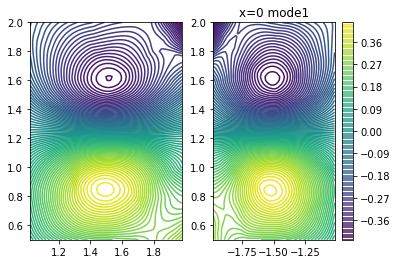

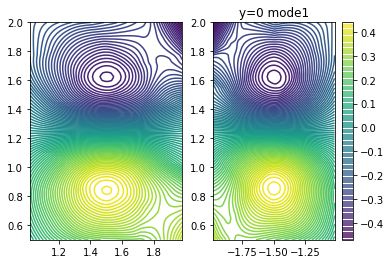

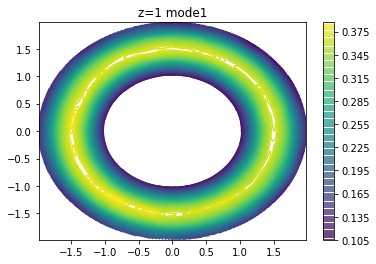

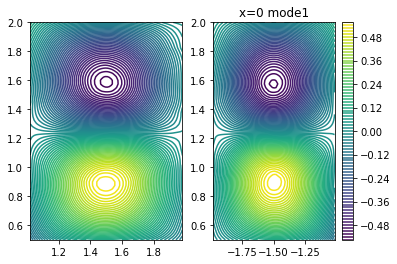

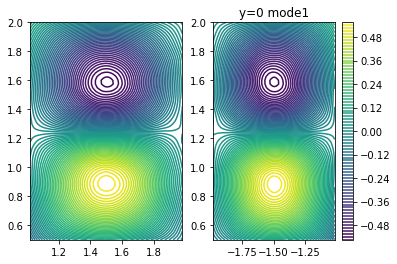

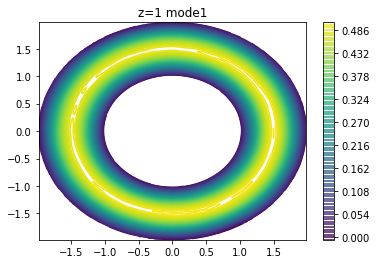

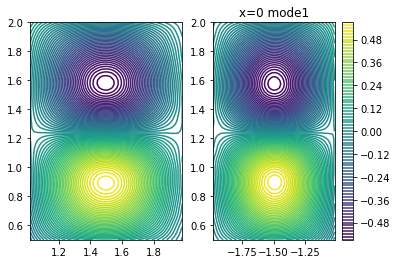

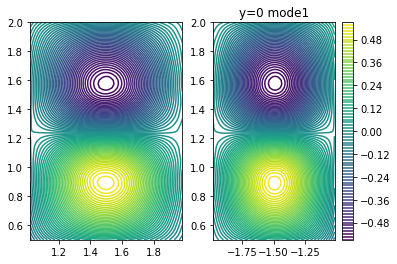

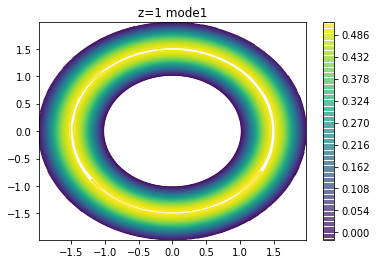

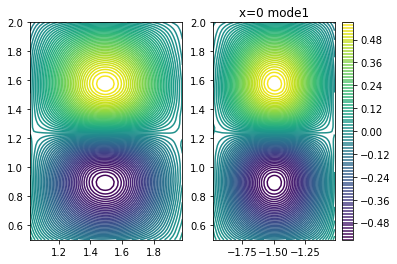

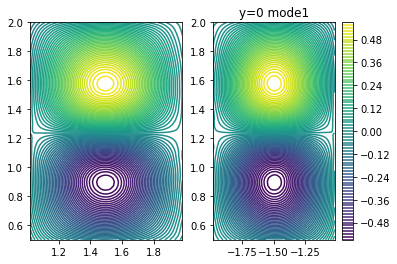

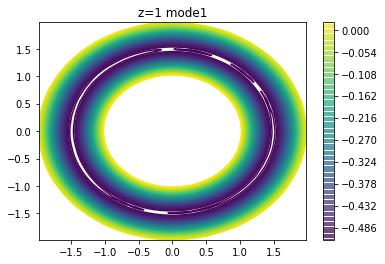

In [10]:
# set up problem
from mshr import *
order = 2
numGrids = np.array([20,30,40,45]) 
a = 1.0
rhosamp   = np.linspace(1.02,1.98,80) # evaluation of H for plotting
thetasamp = np.linspace(0,2*pi,101) 
zsamp     = np.linspace(0.5,2.0,61) 
cylinder1 = Cylinder(Point(0,0,0.5),Point(0,0,2),2,2)
cylinder2 = Cylinder(Point(0,0,0.5),Point(0,0,2),1,1)
hcylinder = cylinder1-cylinder2
# loop over number of grids
for idx in numGrids:
    print('***************************************************')
    print('computation at order',order,'and',idx,'grid points')
    ngrid = idx
    mesh  = generate_mesh(hcylinder,ngrid)
    # reconstruct X
    V  = FunctionSpace(mesh, "Lagrange", order)
    Xr = reconstructVelocityFieldsFromData(mesh,v_interpolation,V)
    print_eigenvalues_save_solutions(Xr,mesh,order,ngrid,rhosamp,thetasamp,zsamp)

In [11]:
mesh